<a href="https://colab.research.google.com/github/kky5738/bp-dleam/blob/main/CNN_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install, Import, define

In [1]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.1 MB/s 


In [2]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sn

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def make_set_featureSelection(input_data:list) -> pd.DataFrame:
    data_set = pd.DataFrame()
    input_data.reverse()
    col_list = []
    for idx, data in enumerate(input_data):
        # dataframe = data.iloc[:, 1:22]
        # dataframe = data.loc[:, ['금융부채비율_w', '금융부채비율2_w', '총자산이익잉여금비율_w', '자기자본순이익률_w', '시장자산영업이익률_w', '총자산영업이익률_w', '총자산증가율_w']]
        dataframe = data.drop([''])
        data_set = pd.concat([data_set, dataframe], axis=1)
        
        for col in dataframe.columns:
            col_list.append(col + f'_{idx+1}')
        
        print('make',data_set.shape)
    print(col_list)
    data_set.columns = col_list
    data_set = data_set.fillna(0) # 결측치는 0으로 채우기

    return data_set

def make_set1(input_data:list) -> pd.DataFrame:
    data_set = pd.DataFrame()
    input_data.reverse()
    col_list = []

    for idx, data in enumerate(input_data):
        dataframe = data.iloc[:, 1:21]
        data_set = pd.concat([data_set, dataframe], axis=1)

        for col in dataframe.columns:
            col_list.append(col + f'_{idx+1}')
        print('make',data_set.shape)
    print(col_list)
    data_set.columns = col_list
    data_set = data_set.fillna(0) # 결측치는 0으로 채우기

    return data_set

def make_set2(years:list) -> pd.DataFrame:
    input = pd.DataFrame()
    years.reverse()

    for year in years:
        input = pd.concat([input, year.iloc[:, 1:25]], axis=1)
        print('make',input.shape)

    input = input.fillna(0) # 결측치는 0으로 채우기

    return input

def make_set3(years:list) -> pd.DataFrame:
    input = pd.DataFrame()
    years.reverse()

    for year in years:
        input = pd.concat([input, year.iloc[:, 1:]], axis=1)
        print('make',input.shape)
    input = input.fillna(0) # 결측치는 0으로 채우기

    return input

def load_data(path:str, years:int, norm:bool = False):
    data = [0] * years
    if norm:
        for i in range(years): data[i] = pd.read_csv(path + f'/data_year{i+1}_macro_norm.csv', encoding='cp949')
    for i in range(years): data[i] = pd.read_csv(path + f'/data_year{i+1}_non_norm.csv', encoding='cp949')

    target = pd.read_csv(path + '/target.csv')
    target = pd.DataFrame(target, columns=['부도여부'])
    
    return data, target

def reset_weights(m:nn.Module):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# 새 섹션

In [8]:
# Dataset 
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels.iloc[idx]
        label = torch.LongTensor(label)

        data = self.data.iloc[idx]
        data = torch.FloatTensor(data)
        data = data.view(1, data.shape[0])
        
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label, num_classes=2)
            label = label.view(2,)
        return data, label

In [9]:
# CNN architecture
class CustomModel(nn.Module):
    def __init__(self, input_size:int, years:int, num_classes=2):
        super(CustomModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(kernel_size=1),
            
            # nn.Conv1d(8, 16, kernel_size=3, padding=1),
            # nn.BatchNorm1d(16),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),
            # nn.MaxPool1d(kernel_size=1),
        )
        self.fcn = nn.Sequential(
            nn.Linear(input_size*16, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes),
        )
    
    def forward(self, input):
        input_feature = self.conv(input)
        input_feature = torch.flatten(input_feature, 1)
        output = self.fcn(input_feature)
        return output

class BestCNN(nn.Module):
    def __init__(self, input_size:int, num_classes=2):
        super(BestCNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(kernel_size=1),

            nn.Conv1d(16, 32, kernel_size=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=1),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(input_size*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(128, num_classes)
        )
    
    def forward(self, input):
        feature = self.conv(input)
        feature = torch.flatten(feature, 1)
        output = self.fully_connected(feature)

        return output

In [10]:
def train_with_fold(model:nn.Module, optimizer, train_loader, scheduler, device):
    model.to(device)

    # criterion = nn.BCELoss().to(device)
    weights = torch.FloatTensor([0.2, 0.8])
    criterion = nn.CrossEntropyLoss(weight=weights).to(device)
    current_loss = 0.0
    best_model = None

    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train() # 학습시킴.
        train_loss = []
        for input, label in iter(train_loader): # train_loader에서 img, text, label 가져옴
            input = input.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad() # 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭하는 걸 방지, 0으로 초기화

            model_pred = model(input) # 예측

            loss = criterion(model_pred, label) # 예측값과 실제값과의 손실 계산
            loss.requires_grad_(True)
            loss.backward() # .backward() 를 호출하면 역전파가 시작
            optimizer.step() # optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정

            train_loss.append(loss.item())
            current_loss += loss.item()
            # if len(train_loss) % 320 == 0:
            #     print('Loss after mini-batch %5d: %.3f' % (len(train_loss), current_loss / 320))
            #     current_loss = 0.0
            
        # 모든 train_loss 가져옴
        tr_loss = np.mean(train_loss)
        
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            # scheduler의 의미: Learning Rate Scheduler => learning rate를 조절한다. 
            # DACON에서는 CosineAnnealingLR 또는 CosineAnnealingWarmRestarts 를 주로 사용한다.
    
    return model # val_score가 가장 높은 모델을 출력

In [76]:
def score_function(real, pred):
    return f1_score(real, pred, average="weighted")
def accuracy_function(real, pred):
    return accuracy_score(real, pred)
    
def inference(model, test_loader, deivce):
    model.to(device)
    model.eval()
    
    ig = IntegratedGradients(model)

    model_preds = []
    true_labels = []
    total_attr = []

    with torch.no_grad():
        for input, target in iter(test_loader):
            input.requires_grad_()
            input = input.float().to(device)
            target = target.to(device)

            model_pred = model(input)

            attr, delta = ig.attribute(input, target=1, return_convergence_delta=True)
            total_attr += attr.detach().cpu().squeeze().numpy().tolist()
            model_preds += model_pred.argmax(1).detach().numpy().tolist()
            true_labels += target.argmax(1).detach().cpu().numpy().tolist()
            
    test_weighted_f1 = score_function(true_labels, model_preds) # 실제 라벨값들과 예측한 라벨값들에 대해 f1 점수 계산
    test_acc = accuracy_function(true_labels, model_preds)
    cm = confusion_matrix(true_labels, model_preds) # get confusion-matrix

    # input data에 따른 예측값들을 model_preds 배열에 넣어 리턴
    return model_preds, test_weighted_f1, test_acc, total_attr, cm

# new
def visualize_importances(feature_names, importances, fold, title="Average Feature Importances", plot=True, axis_title="features", sort:bool=False):
    print(title)
    print(importances.shape)
    
    # 이 부분 멀티 프로세싱으로도 구현 가능할듯?
    feature_importance = [0] * len(feature_names)
    for i in range(len(feature_names)):
        feature_importance[i] = (feature_names[i], importances[i])
        print(i, feature_names[i], f": {importances[i]:.3f}")
        

    if sort:
        sorted_feature = sorted(dict(feature_importance).items(), key=lambda item: item[1], reverse=True)

        for name, value in sorted_feature:
            print(f'{name}: {value:.3f}')

    x_pos = (np.arange(len(feature_names)))
    names = [i for i in range(len(feature_names))]
    if plot:
        title += f' of Fold {fold}'
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title) 

## Once

In [180]:
# Hyperparameter setting
CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':5e-3,
    'BATCH_SIZE':64,
    'SEED':41,
    'YEARS': 1
}

seed_everything(CFG['SEED']) # Seed 고정
PATH = '/content/drive/MyDrive/bankrupt prediction/data/train'

## Set 1

In [66]:
# Hyperparameter setting
CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':5e-3,
    'BATCH_SIZE':64,
    'SEED':41,
    'YEARS': 1
}

seed_everything(CFG['SEED']) # Seed 고정
PATH = '/content/drive/MyDrive/bankrupt prediction/data/train'

data, input_y = load_data(PATH, CFG['YEARS'], norm=True)
input_X = make_set1(data)
print(input_X.shape)

k_folds = 5

# For fold results
results = {}

kfold_st = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=CFG['SEED'])

fold_dataset = CustomDataset(input_X, input_y, target_transform=torch.nn.functional.one_hot)
feature_names = input_X.columns

make (2519, 20)
['부채비율_w_1', '시장부채비율_w_1', '금융부채비율_w_1', '금융부채비율2_w_1', '유동비율_w_1', '고정자산비율_w_1', '총자산영업이익률_w_1', '시장자산영업이익률_w_1', '자기자본순이익률_w_1', '총자산이익잉여금비율_w_1', '총자산증가율_w_1', '매출액증가율_w_1', '당기순이익증가율_w_1', '현금자산비율_w_1', '시장현금자산비율_w_1', '자산대비뎡업현금흐름_w_1', '자산회전율_w_1', '매출채권회전율_w_1', '총매출액유모_w_1', '총자산규모_w_1']
(2519, 20)


----------------------------------------------------
FOLD 1
Reset trainable parameters of layer = Conv1d(1, 16, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=320, out_features=64, bias=True)
Reset trainable parameters of layer = BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=2, bias=True)
Epoch [1], Train Loss : [0.17668]
Epoch [2], Train Loss : [0.14039]
Epoch [3], Train Loss : [0.14185]
Epoch [4], Train Loss : [0.12255]
Epoch [5], Train Loss : [0.12735]
Epoch [6], Train Loss : [0.11868]
Epoch [7], Train Loss : [0.11141]
Epoch [8], Train Loss : [0.11279]
Epoch [9], Train Loss : [0.10969]
Epoch [10], Train Loss : [0.10195]
Epoch [11], Train Loss : [0.10448]
Epoch [12], Train Loss : [0.10352]
Epoch [13], Train Loss : [0.0988

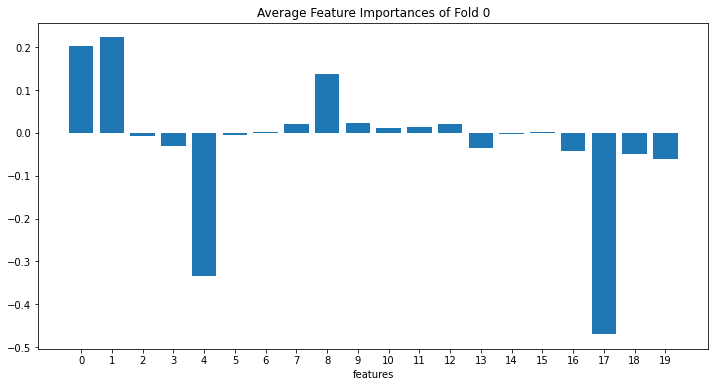

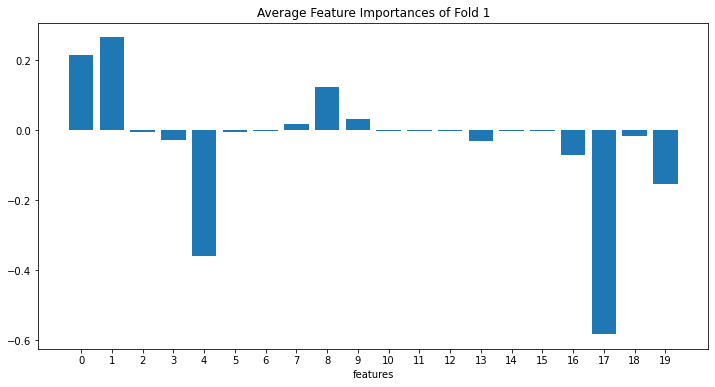

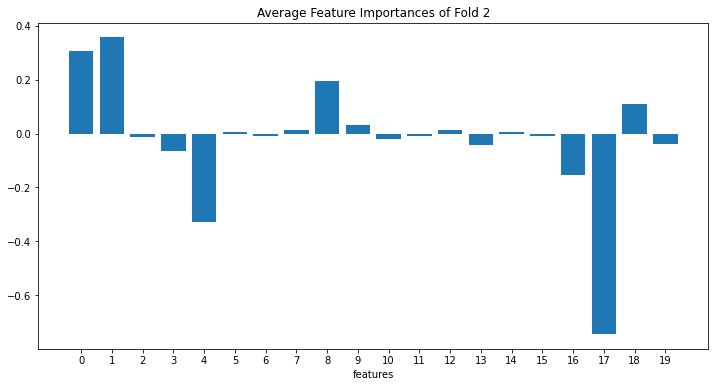

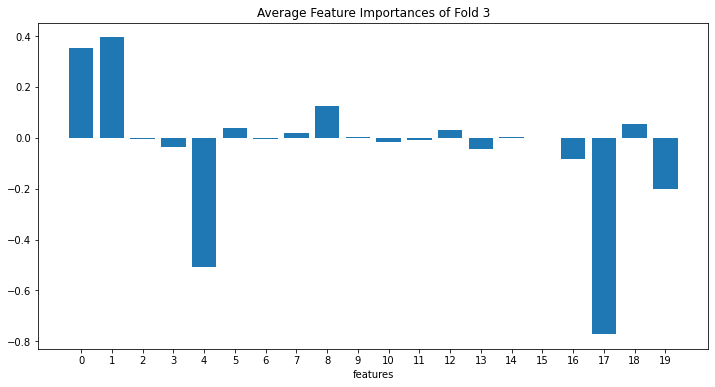

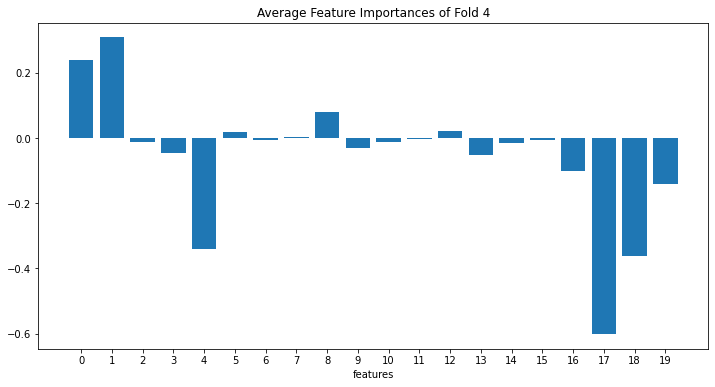

In [181]:
# start training
confusion_list = []
# attr_list = [0] * k_folds
attr_list = [] # for visualization of feature attribution
test_indices = [0]*k_folds # for visualization of feature attribution

print('----------------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold_st.split(fold_dataset, y=input_y)):
    print(f'FOLD {fold+1}')
    

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    # test_data = torch.tensor(input_X.iloc[test_ids].values).type(torch.FloatTensor) # captum # 주석처리 돼도 실행이 된다면 삭제

    trainloader = torch.utils.data.DataLoader(
                      fold_dataset, 
                      batch_size=CFG['BATCH_SIZE'], sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      fold_dataset,
                      batch_size=CFG['BATCH_SIZE'], sampler=test_subsampler)

    model = CustomModel(input_size=input_X.shape[1], years=CFG['YEARS'])
    model.apply(reset_weights)

    optimizer = torch.optim.Adam(params = model.parameters(), lr=CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-4)


    infermodel = train_with_fold(model, optimizer, trainloader, scheduler=scheduler, device=device)
    predict, test_f1, test_acc, total_attr, cm = inference(infermodel, testloader, device)
    confusion_list.append(cm)
    # attr_list[fold] = total_attr
    attr_list.append(total_attr)
    visualize_importances(feature_names, np.mean(total_attr, axis=0), fold)

    test_indices[fold] = test_ids
    
    print(f'Fold: [{fold+1}]  F1 Score: {test_f1:.6f}  Accuracy: {test_acc:.6f}')
    print('----------------------------------------------------')
    results[fold] = (test_f1, test_acc)

### Results of Set 1

In [174]:
# Print fold results
print(f'CNN set1 {CFG["YEARS"]}year using Stratified K-Fold Cross Validation Results For {k_folds} Folds')
print('----------------------------------------------------')
sum_f1 = 0.0
sum_acc = 0.0
for key, (f1, acc) in results.items():
    print(f'Fold {key}: F1 {f1 * 100:.4f} %,  Accuracy {acc * 100:.4f} %')
    sum_f1 += f1
    sum_acc += acc
print(f'Average of F1 Score: {sum_f1/len(results.items()) * 100} %,', end='')
print(f'Average of Accuracy: {sum_acc/len(results.items()) * 100} %')

CNN set1 1year using Stratified K-Fold Cross Validation Results For 5 Folds
----------------------------------------------------
Fold 0: F1 89.0139 %,  Accuracy 88.2937 %
Fold 1: F1 92.3166 %,  Accuracy 92.0635 %
Fold 2: F1 91.1452 %,  Accuracy 90.6746 %
Fold 3: F1 92.1132 %,  Accuracy 91.8651 %
Fold 4: F1 84.3656 %,  Accuracy 82.9026 %
Average of F1 Score: 89.79088457525239 %,Average of Accuracy: 89.15988197797343 %


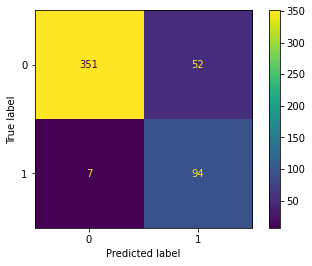

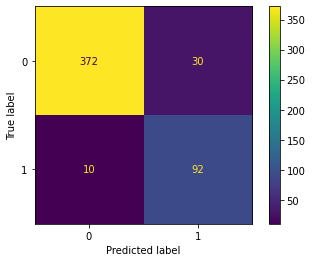

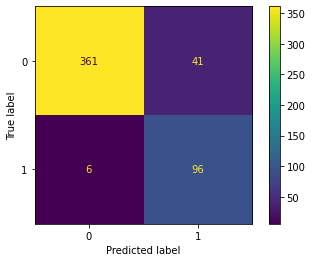

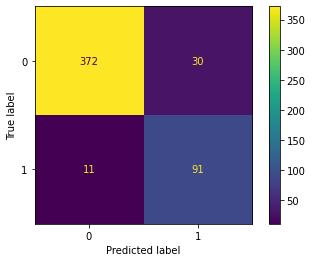

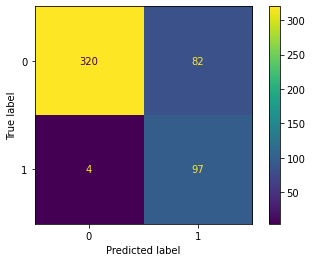

In [175]:
# display normalized confusion-matrix

for cm in confusion_list:
    # cm = cm/np.sum(cm)
    ConfusionMatrixDisplay(cm).plot()

(array([  1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   1.,   2.,
          0.,   1.,   1.,   1.,   1.,   2.,   2.,   0.,   1.,   1.,   3.,
          3.,   0.,   1.,   0.,   0.,   0.,   2.,   2.,   2.,   2.,   2.,
          5.,   3.,   3.,   0.,   2.,   2.,   0.,   2.,   1.,   1.,   5.,
          4.,   2.,   0.,   5.,   3.,   5.,   4.,   1.,   1.,   5.,   4.,
          1.,   2.,   0.,   4.,   3.,   5.,   7.,   4.,   5.,   4.,   9.,
          7.,  11.,   5.,  10.,  16.,  10.,  17.,  13.,  22.,  36.,  57.,
        159.]),
 array([-4.35543453e-01, -4.31185373e-01, -4.26827294e-01, -4.22469214e-01,
        -4.18111134e-01, -4.13753054e-01, -4.09394974e-01, -4.05036894e-01,
        -4.00678814e-01, -3.96320734e-01, -3.91962655e-01, -3.87604575e-01,
        -3.83246495e-01, -3.78888415e-01, -3.74530335e-01, -3.70172255e-01,
        -3.658

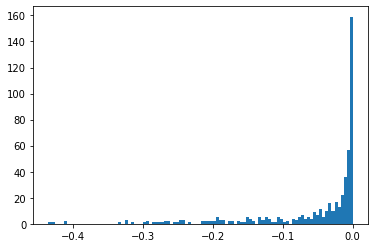

In [179]:
attr = np.array(attr_list[1])
plt.hist(attr[:, 3], 100)

In [177]:
test_features = input_X[test_indices[1]]


KeyError: ignored

In [ ]:
from scipy import stats

# test_features = input_X[test_indices[1]]

bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,4], attr[:,4], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,4], attr[:,4], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

## Set 2



In [ ]:
# Hyperparameter setting
CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':5e-3,
    'BATCH_SIZE':64,
    'SEED':41,
    'YEARS': 1
}

seed_everything(CFG['SEED']) # Seed 고정
PATH = '/content/drive/MyDrive/bankrupt prediction/data/train'

data, input_y = load_data(PATH, CFG['YEARS'], norm=True)
input_X = make_set2(data)
print(input_X.shape)

k_folds = 5

# For fold results
results = {}

kfold_st = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=CFG['SEED'])

fold_dataset = CustomDataset(input_X, input_y, target_transform=torch.nn.functional.one_hot)
feature_names = input_X.columns

make (2519, 24)
(2519, 24)


In [ ]:
"""
거시경제 데이터 분포
80% 2021년
20% 2000년~2020년

따라서 거시경제 데이터를 scaling이나 normalization 하더라도 의미가 없음. 이미 데이터 자체가 안좋아서
"""

----------------------------------------------------
FOLD 1
Reset trainable parameters of layer = Conv1d(1, 16, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=384, out_features=64, bias=True)
Reset trainable parameters of layer = BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=2, bias=True)
Epoch [1], Train Loss : [0.17539]
Epoch [2], Train Loss : [0.13746]
Epoch [3], Train Loss : [0.13556]
Epoch [4], Train Loss : [0.12869]
Epoch [5], Train Loss : [0.12059]
Epoch [6], Train Loss : [0.13332]
Epoch [7], Train Loss : [0.12037]
Epoch [8], Train Loss : [0.12655]
Epoch [9], Train Loss : [0.11938]
Epoch [10], Train Loss : [0.10032]
Epoch [11], Train Loss : [0.10102]
Epoch [12], Train Loss : [0.09958]
Epoch [13], Train Loss : [0.1034

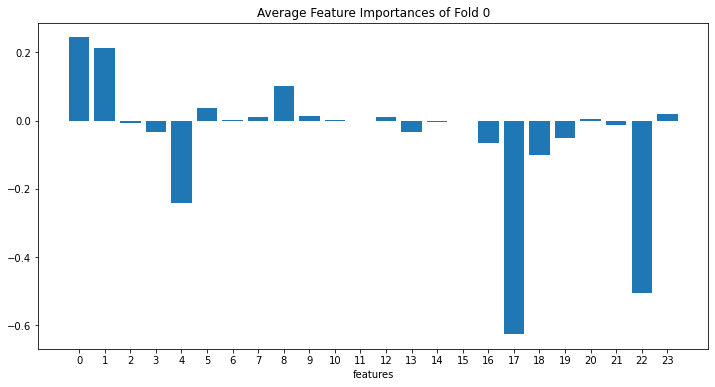

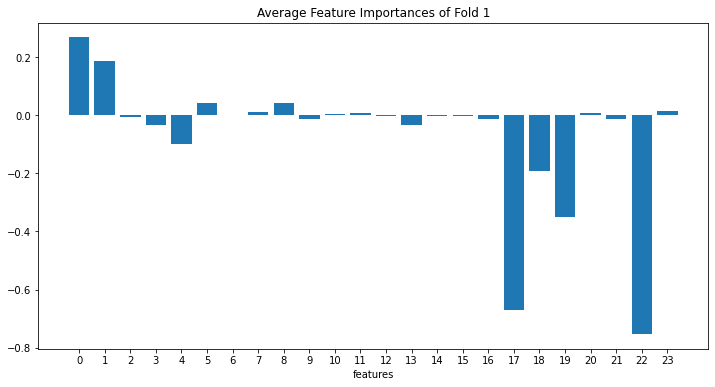

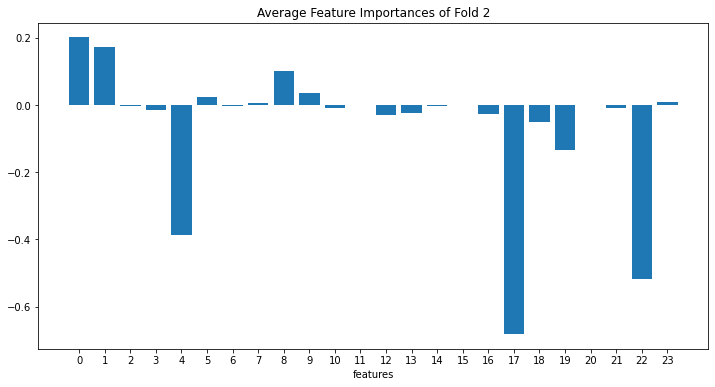

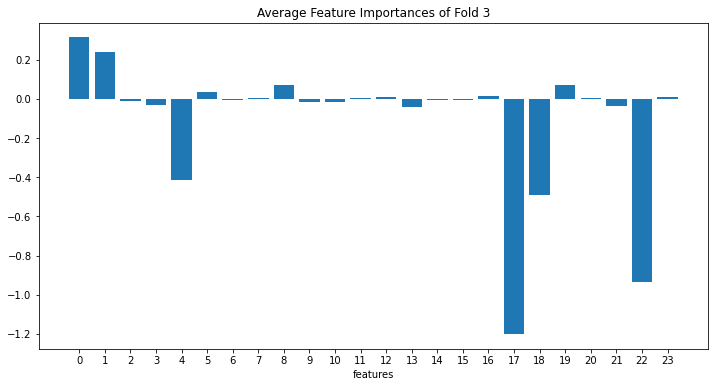

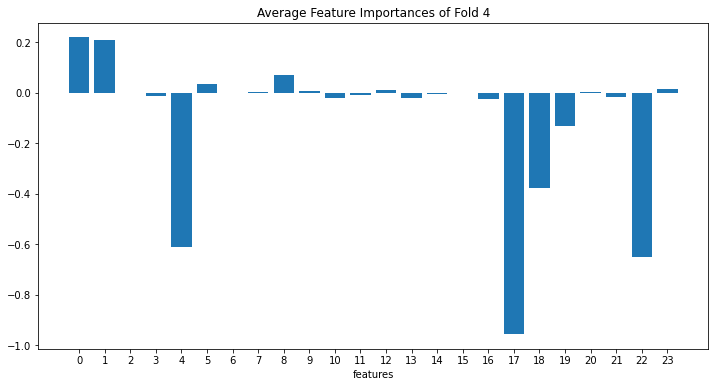

In [ ]:
# start training
confusion_list = []
attr_list = []

print('----------------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold_st.split(fold_dataset, y=input_y)):
    print(f'FOLD {fold+1}')
    

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    test_data = torch.tensor(input_X.iloc[test_ids].values).type(torch.FloatTensor) # captum

    trainloader = torch.utils.data.DataLoader(
                      fold_dataset, 
                      batch_size=CFG['BATCH_SIZE'], sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      fold_dataset,
                      batch_size=CFG['BATCH_SIZE'], sampler=test_subsampler)

    model = CustomModel(input_size=input_X.shape[1], years=CFG['YEARS'])
    model.apply(reset_weights)

    optimizer = torch.optim.Adam(params = model.parameters(), lr=CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-4)


    infermodel = train_with_fold(model, optimizer, trainloader, scheduler=scheduler, device=device)
    predict, test_f1, test_acc, total_attr, cm = inference(infermodel, testloader, device)
    confusion_list.append(cm)

    visualize_importances(feature_names, np.mean(total_attr, axis=0), fold)


    print(f'Fold: [{fold+1}]  F1 Score: {test_f1:.6f}  Accuracy: {test_acc:.6f}')
    print('----------------------------------------------------')
    results[fold] = (test_f1, test_acc)

### Results of Set 2

In [ ]:
# Print fold results
print(f'CNN set1 {CFG["YEARS"]}year using Stratified K-Fold Cross Validation Results For {k_folds} Folds')
print('----------------------------------------------------')
sum_f1 = 0.0
sum_acc = 0.0
for key, (f1, acc) in results.items():
    print(f'Fold {key}: F1 {f1 * 100:.4f} %,  Accuracy {acc * 100:.4f} %')
    sum_f1 += f1
    sum_acc += acc
print(f'Average of F1 Score: {sum_f1/len(results.items()) * 100} %,', end='')
print(f'Average of Accuracy: {sum_acc/len(results.items()) * 100} %')

CNN set1 1year using Stratified K-Fold Cross Validation Results For 5 Folds
----------------------------------------------------
Fold 0: F1 89.1662 %,  Accuracy 88.4921 %
Fold 1: F1 93.8873 %,  Accuracy 93.6508 %
Fold 2: F1 89.2227 %,  Accuracy 88.4921 %
Fold 3: F1 90.5909 %,  Accuracy 90.0794 %
Fold 4: F1 88.3348 %,  Accuracy 87.4751 %
Average of F1 Score: 90.24037701535714 %,Average of Accuracy: 89.6378869639307 %


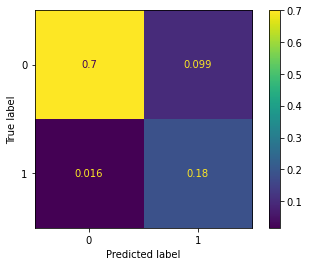

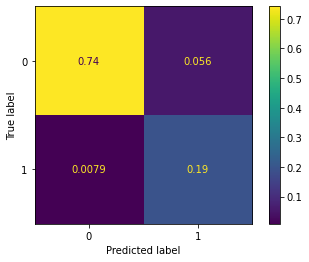

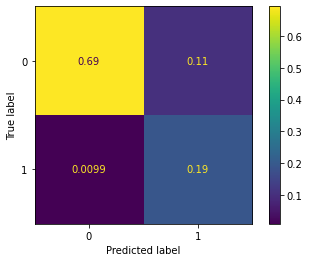

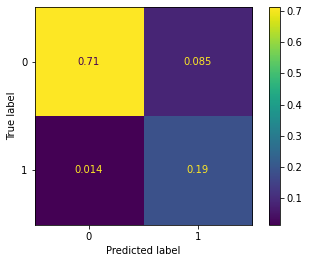

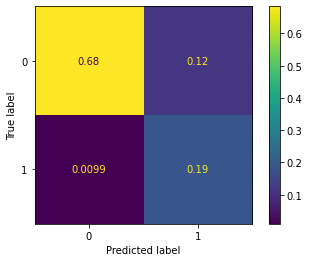

In [ ]:
# display normalized confusion-matrix

for cm in confusion_list:
    cm = cm/np.sum(cm)
    ConfusionMatrixDisplay(cm).plot()

## Set 3

In [ ]:
# Hyperparameter setting
CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':5e-3,
    'BATCH_SIZE':64,
    'SEED':41,
    'YEARS': 1
}

seed_everything(CFG['SEED']) # Seed 고정
PATH = '/content/drive/MyDrive/bankrupt prediction/data/train'

data, input_y = load_data(PATH, CFG['YEARS'], norm=True)
input_X = make_set3(data)
print(input_X.shape)

k_folds = 5

# For fold results
results = {}

kfold_st = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=CFG['SEED'])

fold_dataset = CustomDataset(input_X, input_y, target_transform=torch.nn.functional.one_hot)
feature_names = input_X.columns

make (2519, 32)
(2519, 32)


----------------------------------------------------
FOLD 1
Reset trainable parameters of layer = Conv1d(1, 16, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=64, bias=True)
Reset trainable parameters of layer = BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=2, bias=True)
Epoch [1], Train Loss : [0.20912]
Epoch [2], Train Loss : [0.19277]
Epoch [3], Train Loss : [0.19570]
Epoch [4], Train Loss : [0.17537]
Epoch [5], Train Loss : [0.17680]
Epoch [6], Train Loss : [0.16684]
Epoch [7], Train Loss : [0.15292]
Epoch [8], Train Loss : [0.14465]
Epoch [9], Train Loss : [0.13080]
Epoch [10], Train Loss : [0.11053]
Epoch [11], Train Loss : [0.09657]
Epoch [12], Train Loss : [0.08680]
Epoch [13], Train Loss : [0.0844

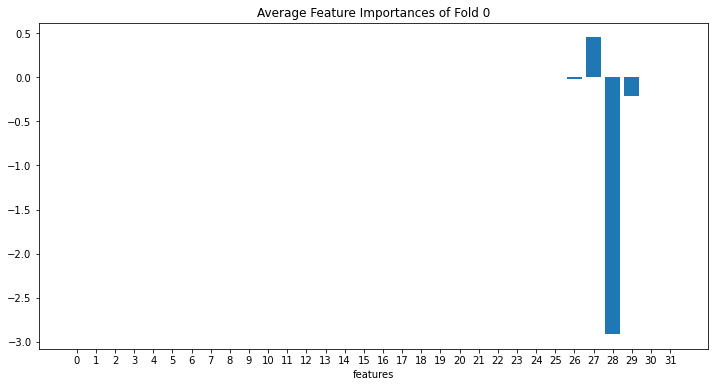

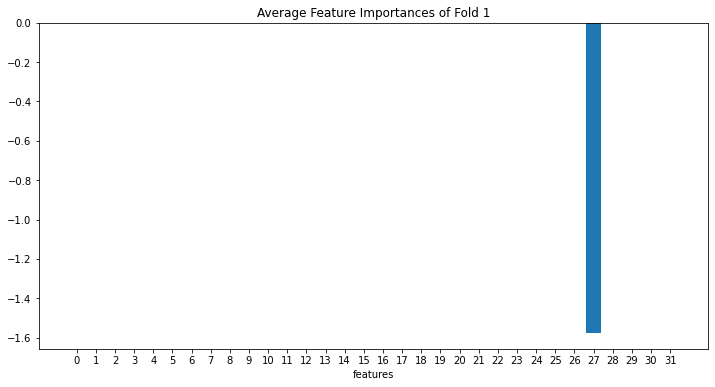

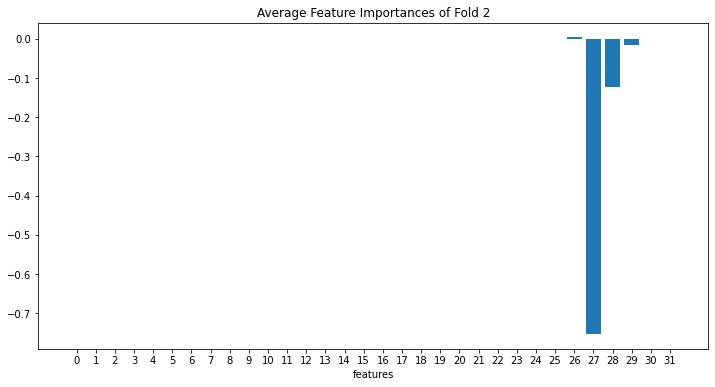

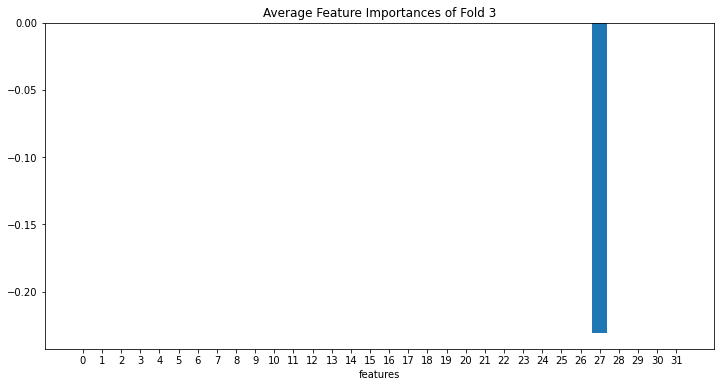

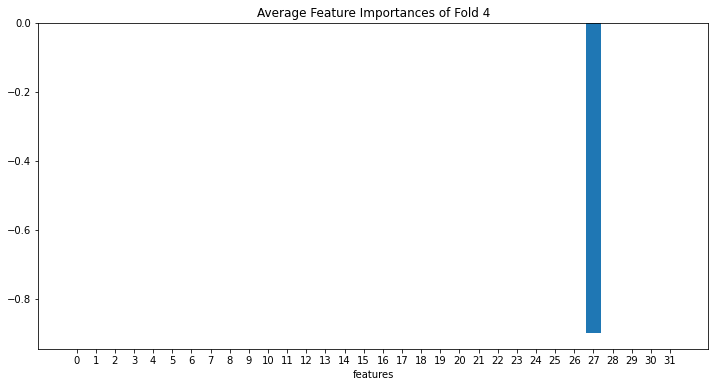

In [ ]:
# start training
confusion_list = []
attr_list = []

print('----------------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold_st.split(fold_dataset, y=input_y)):
    print(f'FOLD {fold+1}')
    

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    test_data = torch.tensor(input_X.iloc[test_ids].values).type(torch.FloatTensor) # captum

    trainloader = torch.utils.data.DataLoader(
                      fold_dataset, 
                      batch_size=CFG['BATCH_SIZE'], sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      fold_dataset,
                      batch_size=CFG['BATCH_SIZE'], sampler=test_subsampler)

    model = CustomModel(input_size=input_X.shape[1], years=CFG['YEARS'])
    model.apply(reset_weights)

    optimizer = torch.optim.Adam(params = model.parameters(), lr=CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-4)


    infermodel = train_with_fold(model, optimizer, trainloader, scheduler=scheduler, device=device)
    predict, test_f1, test_acc, total_attr, cm = inference(infermodel, testloader, device)
    confusion_list.append(cm)

    visualize_importances(feature_names, np.mean(total_attr, axis=0), fold)


    print(f'Fold: [{fold+1}]  F1 Score: {test_f1:.6f}  Accuracy: {test_acc:.6f}')
    print('----------------------------------------------------')
    results[fold] = (test_f1, test_acc)

### Results of Set 3

In [ ]:
# Print fold results
print(f'CNN set3 {CFG["YEARS"]}year using Stratified K-Fold Cross Validation Results For {k_folds} Folds')
print('----------------------------------------------------')
sum_f1 = 0.0
sum_acc = 0.0
for key, (f1, acc) in results.items():
    print(f'Fold {key}: F1 {f1 * 100:.4f} %,  Accuracy {acc * 100:.4f} %')
    sum_f1 += f1
    sum_acc += acc
print(f'Average of F1 Score: {sum_f1/len(results.items()) * 100} %,', end='')
print(f'Average of Accuracy: {sum_acc/len(results.items()) * 100} %')

CNN set3 1year using Stratified K-Fold Cross Validation Results For 5 Folds
----------------------------------------------------
Fold 0: F1 6.6909 %,  Accuracy 20.0397 %
Fold 1: F1 98.3881 %,  Accuracy 98.4127 %
Fold 2: F1 6.8128 %,  Accuracy 20.2381 %
Fold 3: F1 6.8128 %,  Accuracy 20.2381 %
Fold 4: F1 6.7153 %,  Accuracy 20.0795 %
Average of F1 Score: 25.084008889036514 %,Average of Accuracy: 35.80161885827889 %


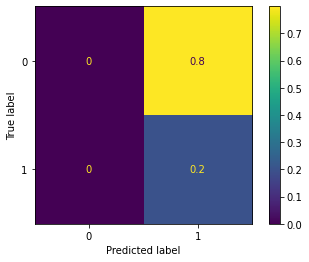

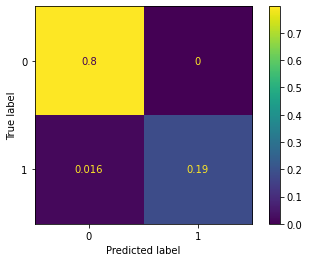

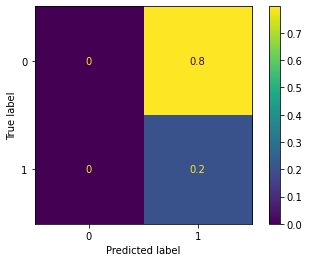

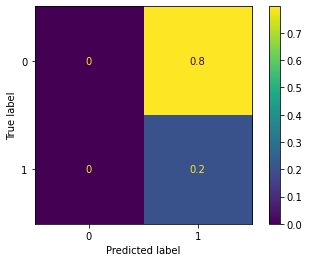

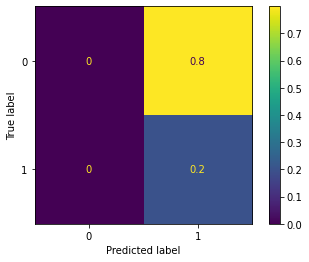

In [ ]:
# display normalized confusion-matrix

for cm in confusion_list:
    cm = cm/np.sum(cm)
    ConfusionMatrixDisplay(cm).plot()

## Best architecture

In [13]:
data, input_y = load_data(PATH, CFG['YEARS'], norm=True)
input_X = make_set1(data)
print(input_X.shape)

k_folds = 5

# For fold results
results = {}

kfold_st = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=CFG['SEED'])

fold_dataset = CustomDataset(input_X, input_y, target_transform=torch.nn.functional.one_hot)
feature_names = input_X.columns

make (2519, 20)
['부채비율_w_1', '시장부채비율_w_1', '금융부채비율_w_1', '금융부채비율2_w_1', '유동비율_w_1', '고정자산비율_w_1', '총자산영업이익률_w_1', '시장자산영업이익률_w_1', '자기자본순이익률_w_1', '총자산이익잉여금비율_w_1', '총자산증가율_w_1', '매출액증가율_w_1', '당기순이익증가율_w_1', '현금자산비율_w_1', '시장현금자산비율_w_1', '자산대비뎡업현금흐름_w_1', '자산회전율_w_1', '매출채권회전율_w_1', '총매출액유모_w_1', '총자산규모_w_1']
(2519, 20)


In [24]:
print(feature_names)
# 2,3,4,5,13,14,16,17,18,19
# data.drop('금융부채비율')
lis = [3, 4, 5, 13, 14, 16, 17, 18, 19]
tg = []
for i, col in enumerate(feature_names):
    print(i)
    if int(i) in lis:
        print(i, col)
        tg.append(col)
print(tg)

Index(['부채비율_w_1', '시장부채비율_w_1', '금융부채비율_w_1', '금융부채비율2_w_1', '유동비율_w_1',
       '고정자산비율_w_1', '총자산영업이익률_w_1', '시장자산영업이익률_w_1', '자기자본순이익률_w_1',
       '총자산이익잉여금비율_w_1', '총자산증가율_w_1', '매출액증가율_w_1', '당기순이익증가율_w_1',
       '현금자산비율_w_1', '시장현금자산비율_w_1', '자산대비뎡업현금흐름_w_1', '자산회전율_w_1',
       '매출채권회전율_w_1', '총매출액유모_w_1', '총자산규모_w_1'],
      dtype='object')
0
1
2
3
3 금융부채비율2_w_1
4
4 유동비율_w_1
5
5 고정자산비율_w_1
6
7
8
9
10
11
12
13
13 현금자산비율_w_1
14
14 시장현금자산비율_w_1
15
16
16 자산회전율_w_1
17
17 매출채권회전율_w_1
18
18 총매출액유모_w_1
19
19 총자산규모_w_1
['금융부채비율2_w_1', '유동비율_w_1', '고정자산비율_w_1', '현금자산비율_w_1', '시장현금자산비율_w_1', '자산회전율_w_1', '매출채권회전율_w_1', '총매출액유모_w_1', '총자산규모_w_1']


----------------------------------------------------
FOLD 1
Reset trainable parameters of layer = Conv1d(1, 16, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv1d(16, 32, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=640, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)
Epoch [1], Train Loss : [0.18642]
Epoch [2], Train Loss : [0.14176]
Epoch [3], Train Loss : [0.13710]
Epoch [4], Train Loss : [0.12439]
Epoch [5], Train Loss : [0.11025]
Epoch [6], Train Loss : [0.11886]
Epoch [7], Train Loss : [0.12043]


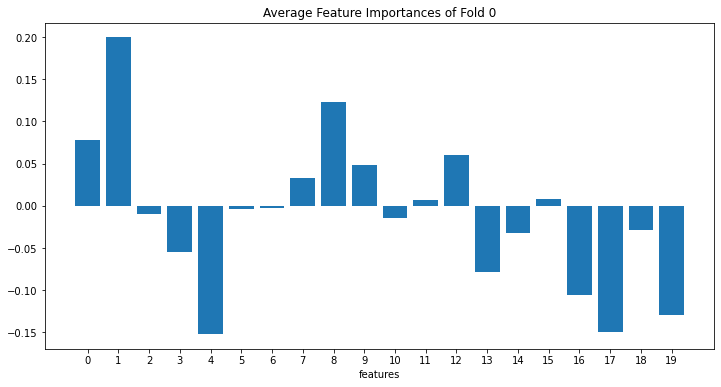

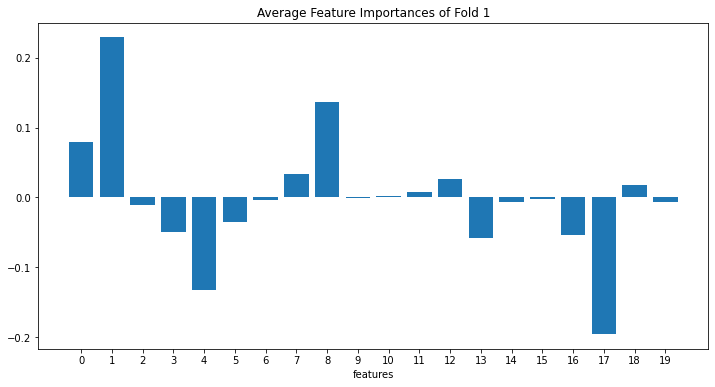

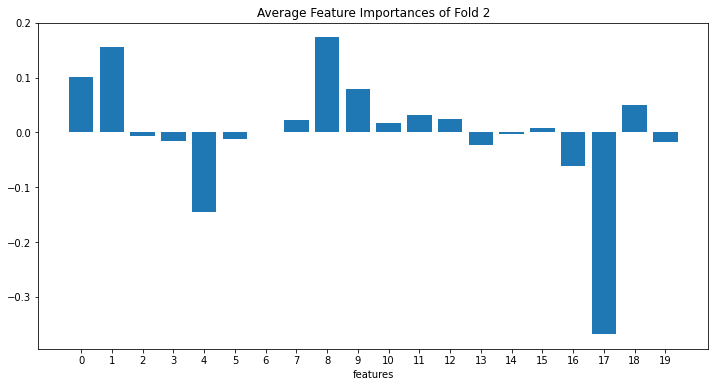

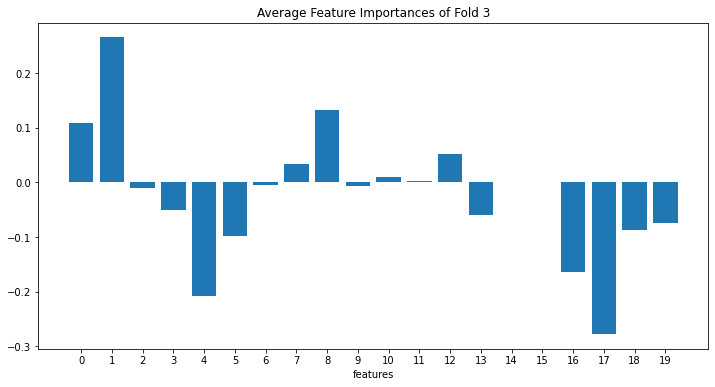

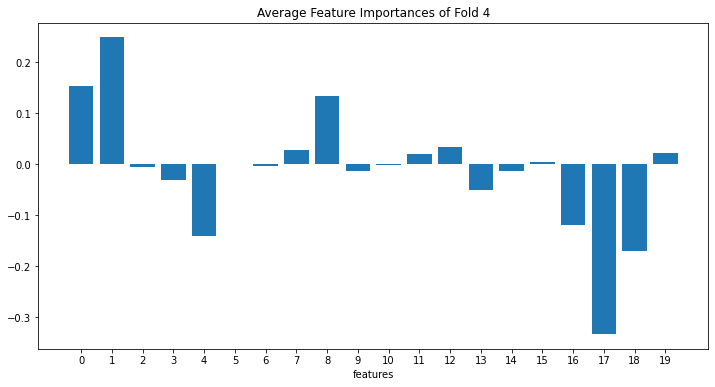

In [ ]:
# start training
confusion_list = []
attr_list = []

print('----------------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold_st.split(fold_dataset, y=input_y)):
    print(f'FOLD {fold+1}')
    

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    # test_data = torch.tensor(input_X.iloc[test_ids].values).type(torch.FloatTensor) # captum # 주석처리 돼도 실행이 된다면 삭제

    trainloader = torch.utils.data.DataLoader(
                      fold_dataset, 
                      batch_size=CFG['BATCH_SIZE'], sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      fold_dataset,
                      batch_size=CFG['BATCH_SIZE'], sampler=test_subsampler)

    # model = CustomModel(input_size=input_X.shape[1], years=CFG['YEARS'])
    model = BestCNN(input_size=input_X.shape[1])
    model.apply(reset_weights)

    optimizer = torch.optim.Adam(params = model.parameters(), lr=CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-4)


    infermodel = train_with_fold(model, optimizer, trainloader, scheduler=scheduler, device=device)
    predict, test_f1, test_acc, total_attr, cm = inference(infermodel, testloader, device)
    confusion_list.append(cm)

    visualize_importances(feature_names, np.mean(total_attr, axis=0), fold)


    print(f'Fold: [{fold+1}]  F1 Score: {test_f1:.6f}  Accuracy: {test_acc:.6f}')
    print('----------------------------------------------------')
    results[fold] = (test_f1, test_acc)

In [ ]:
# Print fold results
print(f'CNN set3 {CFG["YEARS"]}year using Stratified K-Fold Cross Validation Results For {k_folds} Folds')
print('----------------------------------------------------')
sum_f1 = 0.0
sum_acc = 0.0
for key, (f1, acc) in results.items():
    print(f'Fold {key}: F1 {f1 * 100:.4f} %,  Accuracy {acc * 100:.4f} %')
    sum_f1 += f1
    sum_acc += acc
print(f'Average of F1 Score: {sum_f1/len(results.items()) * 100} %,', end='')
print(f'Average of Accuracy: {sum_acc/len(results.items()) * 100} %')

CNN set3 1year using Stratified K-Fold Cross Validation Results For 5 Folds
----------------------------------------------------
Fold 0: F1 91.0859 %,  Accuracy 90.6746 %
Fold 1: F1 91.9984 %,  Accuracy 91.6667 %
Fold 2: F1 93.9829 %,  Accuracy 93.8492 %
Fold 3: F1 93.2289 %,  Accuracy 93.2540 %
Fold 4: F1 91.9197 %,  Accuracy 91.6501 %
Average of F1 Score: 92.44318693628686 %,Average of Accuracy: 92.2189087696046 %


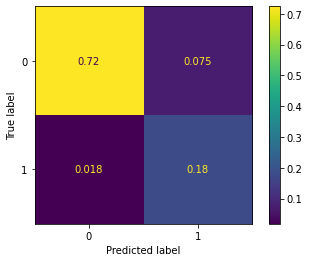

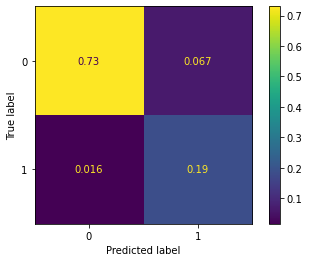

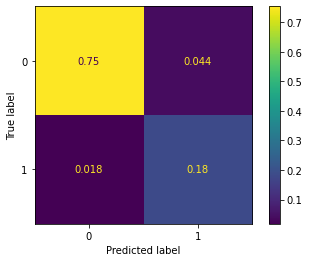

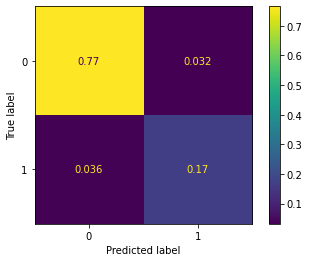

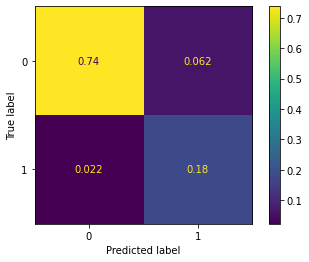

In [ ]:
# display normalized confusion-matrix

for cm in confusion_list:
    cm = cm/np.sum(cm)
    ConfusionMatrixDisplay(cm).plot()

In [ ]:
# 2,3,4,5,13,14,16,17,18,19